# Autoencoders
1. Обучить многослойный автокодировщик:  
а. отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем  
б. сделать tSNE над 32-мерным латентным слоем, отрисовать представление

2. Обучить шумный автокодировщик:  
а. Добавить ко входным данным нормальный шум  
б. Сделать отражение части изображения  
в. Отрисовать карты активаций нейронов первого слоя  

## Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Load Data

In [ ]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset_path = './MNIST_data'
train_batch_size = 64
test_batch_size = 512

train_data = datasets.MNIST(dataset_path, train=True, download=True, transform=mnist_transform)
test_data = datasets.MNIST(dataset_path, train=False, download=True, transform=mnist_transform)
train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

In [ ]:
def plot_mnist(images, tags, shape=(5, 10)):
    assert len(images) == shape[0] * shape[1]
    fig, axes = plt.subplots(*shape)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.matshow(images[i, 0, :, :], cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(tags[i].item())
    return fig

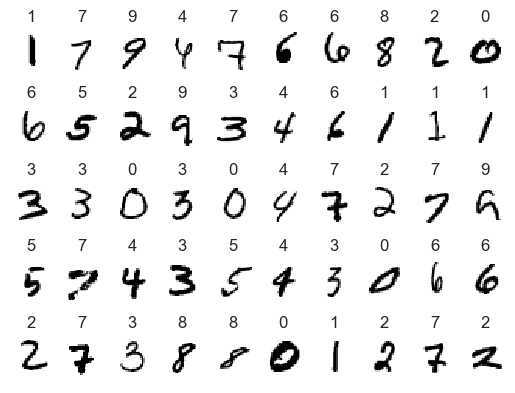

In [ ]:
torch.manual_seed(77)
images, tags = next(iter(train_loader))
plot_mnist(images[:50], tags[:50])
plt.show()

## Define classes

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

class Network(nn.Module):
    def __init__(self, latent_size=10):
        super(Network, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def forward(self, x):
        x = x.view(-1, 28*28)
        code = self.encoder(x)
        out = self.decoder(code)
        return out

    def encode(self, x):
        with torch.no_grad():
            return self.encoder(x)

    def decode(self, x):
        with torch.no_grad():
            return self.decoder(x)

## Train and test functions

In [ ]:
def train(model, device, loader, optimizer, criterion, epoch, log=None):
    model.train()
    train_loss = 0

    n = len(loader)

    for batch_ind, (data, _) in tqdm(enumerate(loader), total=n):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.view(-1, 28*28))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/n
    tqdm.write('\nTrain set: Average loss: {:.4f}'.format(train_loss))

    if log is not None:
        log['train_loss'].append(train_loss)

def test(model, device, loader, criterion, log=None):
    model.eval()
    test_loss = 0
    n = len(loader)

    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = model(data)
            test_loss += criterion(output, data.view(-1, 28*28)).item()
    test_loss = test_loss/n
    tqdm.write('Test set: Average loss: {:.4f}'.format(test_loss))

    if log is not None:
        log['test_loss'].append(test_loss)

def train_test(model, device, optimizer, criterion, epoch, log=None):
    print('Epoch: ', epoch)
    train(model, device, train_loader, optimizer, criterion, epoch, log)
    test(model, device, test_loader, criterion, log)

## Test run
Обучим автокодировщик со стандартными параметрами и визуализируем результаты.

In [ ]:
test_autoencoder = Network().cuda()
optimizer = optim.Adam(test_autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()
log = {
    'train_loss': [],
    'test_loss': []
}
device = 'cuda:0'
num_epoch = 25

for epoch in range(1, num_epoch+1):
    train_test(test_autoencoder, device, optimizer, criterion, epoch, log)
torch.save(test_autoencoder, './cache/test_autoencoder')

Epoch:  1


100%|██████████| 938/938 [00:14<00:00, 66.25it/s]



Train set: Average loss: 0.6616
Test set: Average loss: 0.5888
Epoch:  2


100%|██████████| 938/938 [00:12<00:00, 74.57it/s]



Train set: Average loss: 0.5647
Test set: Average loss: 0.5502
Epoch:  3


100%|██████████| 938/938 [00:12<00:00, 77.04it/s]



Train set: Average loss: 0.5364
Test set: Average loss: 0.5300
Epoch:  4


100%|██████████| 938/938 [00:12<00:00, 74.98it/s]



Train set: Average loss: 0.5211
Test set: Average loss: 0.5191
Epoch:  5


100%|██████████| 938/938 [00:13<00:00, 70.45it/s]



Train set: Average loss: 0.5130
Test set: Average loss: 0.5132
Epoch:  6


100%|██████████| 938/938 [00:12<00:00, 74.16it/s]



Train set: Average loss: 0.5082
Test set: Average loss: 0.5093
Epoch:  7


100%|██████████| 938/938 [00:13<00:00, 71.80it/s]



Train set: Average loss: 0.5050
Test set: Average loss: 0.5065
Epoch:  8


100%|██████████| 938/938 [00:12<00:00, 73.99it/s]



Train set: Average loss: 0.5027
Test set: Average loss: 0.5046
Epoch:  9


100%|██████████| 938/938 [00:12<00:00, 75.95it/s]



Train set: Average loss: 0.5011
Test set: Average loss: 0.5032
Epoch:  10


100%|██████████| 938/938 [00:13<00:00, 69.58it/s]



Train set: Average loss: 0.4998
Test set: Average loss: 0.5022
Epoch:  11


100%|██████████| 938/938 [00:12<00:00, 76.85it/s]



Train set: Average loss: 0.4988
Test set: Average loss: 0.5011
Epoch:  12


100%|██████████| 938/938 [00:12<00:00, 73.41it/s]



Train set: Average loss: 0.4979
Test set: Average loss: 0.5003
Epoch:  13


100%|██████████| 938/938 [00:12<00:00, 75.63it/s]



Train set: Average loss: 0.4973
Test set: Average loss: 0.4997
Epoch:  14


100%|██████████| 938/938 [00:12<00:00, 74.51it/s]



Train set: Average loss: 0.4967
Test set: Average loss: 0.4990
Epoch:  15


100%|██████████| 938/938 [00:12<00:00, 74.96it/s]



Train set: Average loss: 0.4963
Test set: Average loss: 0.4988
Epoch:  16


100%|██████████| 938/938 [00:12<00:00, 73.37it/s]



Train set: Average loss: 0.4958
Test set: Average loss: 0.4989
Epoch:  17


100%|██████████| 938/938 [00:13<00:00, 70.02it/s]



Train set: Average loss: 0.4955
Test set: Average loss: 0.4979
Epoch:  18


100%|██████████| 938/938 [00:13<00:00, 72.02it/s]



Train set: Average loss: 0.4951
Test set: Average loss: 0.4977
Epoch:  19


100%|██████████| 938/938 [00:12<00:00, 74.27it/s]



Train set: Average loss: 0.4949
Test set: Average loss: 0.4973
Epoch:  20


100%|██████████| 938/938 [00:12<00:00, 74.71it/s]



Train set: Average loss: 0.4946
Test set: Average loss: 0.4970
Epoch:  21


100%|██████████| 938/938 [00:12<00:00, 73.15it/s]



Train set: Average loss: 0.4943
Test set: Average loss: 0.4967
Epoch:  22


100%|██████████| 938/938 [00:12<00:00, 74.01it/s]



Train set: Average loss: 0.4941
Test set: Average loss: 0.4967
Epoch:  23


100%|██████████| 938/938 [00:13<00:00, 70.27it/s]



Train set: Average loss: 0.4939
Test set: Average loss: 0.4965
Epoch:  24


100%|██████████| 938/938 [00:13<00:00, 69.90it/s]



Train set: Average loss: 0.4938
Test set: Average loss: 0.4960
Epoch:  25


100%|██████████| 938/938 [00:13<00:00, 69.52it/s]



Train set: Average loss: 0.4936
Test set: Average loss: 0.4960


In [ ]:
test_autoencoder = torch.load('./cache/test_autoencoder')

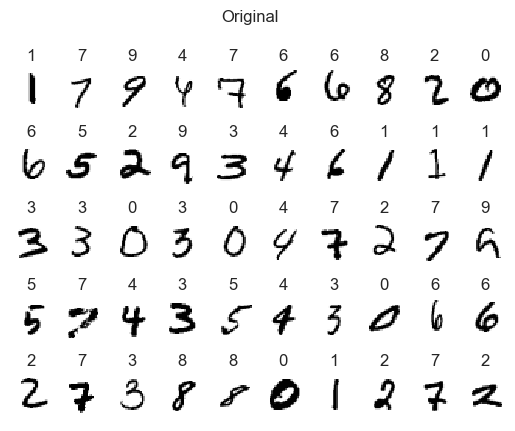

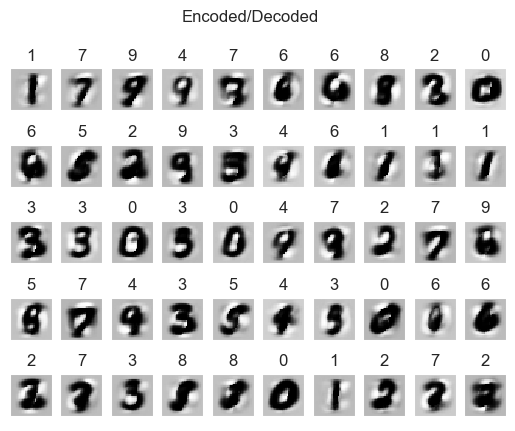

In [ ]:
torch.manual_seed(77)
images, tags = next(iter(train_loader))
fig1 = plot_mnist(images[:50], tags[:50])
fig1.suptitle('Original')
plt.show()
with torch.no_grad():
    new_images = test_autoencoder.forward(images.to(device)).view(64, 1, 28, 28).cpu()
fig2 = plot_mnist(new_images[:50], tags[:50])
fig2.suptitle('Encoded/Decoded')
plt.show()

## 2D latent layer

In [ ]:
encoder_2d = Network(2).cuda()
optimizer = optim.Adam(encoder_2d.parameters(), lr=1e-4)
criterion = nn.MSELoss()
log_2d = {
    'train_loss': [],
    'test_loss': []
}
device = 'cuda:0'
num_epoch = 25

for epoch in range(1, num_epoch+1):
    train_test(encoder_2d, device, optimizer, criterion, epoch, log_2d)
torch.save(encoder_2d, './cache/encoder_2d')

Epoch:  1


100%|██████████| 938/938 [00:13<00:00, 69.76it/s]



Train set: Average loss: 1.0927
Test set: Average loss: 1.0614
Epoch:  2


100%|██████████| 938/938 [00:13<00:00, 70.50it/s]



Train set: Average loss: 0.9931
Test set: Average loss: 0.9447
Epoch:  3


100%|██████████| 938/938 [00:13<00:00, 70.78it/s]



Train set: Average loss: 0.8789
Test set: Average loss: 0.8347
Epoch:  4


100%|██████████| 938/938 [00:13<00:00, 70.26it/s]



Train set: Average loss: 0.7917
Test set: Average loss: 0.7682
Epoch:  5


100%|██████████| 938/938 [00:13<00:00, 70.67it/s]



Train set: Average loss: 0.7462
Test set: Average loss: 0.7374
Epoch:  6


100%|██████████| 938/938 [00:13<00:00, 71.48it/s]



Train set: Average loss: 0.7257
Test set: Average loss: 0.7232
Epoch:  7


100%|██████████| 938/938 [00:13<00:00, 70.99it/s]



Train set: Average loss: 0.7152
Test set: Average loss: 0.7147
Epoch:  8


100%|██████████| 938/938 [00:13<00:00, 70.82it/s]



Train set: Average loss: 0.7081
Test set: Average loss: 0.7079
Epoch:  9


100%|██████████| 938/938 [00:13<00:00, 71.46it/s]



Train set: Average loss: 0.7013
Test set: Average loss: 0.7009
Epoch:  10


100%|██████████| 938/938 [00:13<00:00, 71.71it/s]



Train set: Average loss: 0.6941
Test set: Average loss: 0.6934
Epoch:  11


100%|██████████| 938/938 [00:13<00:00, 71.88it/s]



Train set: Average loss: 0.6867
Test set: Average loss: 0.6862
Epoch:  12


100%|██████████| 938/938 [00:13<00:00, 71.76it/s]



Train set: Average loss: 0.6801
Test set: Average loss: 0.6803
Epoch:  13


100%|██████████| 938/938 [00:13<00:00, 70.81it/s]



Train set: Average loss: 0.6748
Test set: Average loss: 0.6755
Epoch:  14


100%|██████████| 938/938 [00:12<00:00, 72.61it/s]



Train set: Average loss: 0.6706
Test set: Average loss: 0.6716
Epoch:  15


100%|██████████| 938/938 [00:12<00:00, 73.00it/s]



Train set: Average loss: 0.6671
Test set: Average loss: 0.6684
Epoch:  16


100%|██████████| 938/938 [00:12<00:00, 74.65it/s]



Train set: Average loss: 0.6643
Test set: Average loss: 0.6657
Epoch:  17


100%|██████████| 938/938 [00:12<00:00, 73.98it/s]



Train set: Average loss: 0.6619
Test set: Average loss: 0.6635
Epoch:  18


100%|██████████| 938/938 [00:12<00:00, 74.12it/s]



Train set: Average loss: 0.6599
Test set: Average loss: 0.6616
Epoch:  19


100%|██████████| 938/938 [00:13<00:00, 71.13it/s]



Train set: Average loss: 0.6581
Test set: Average loss: 0.6599
Epoch:  20


100%|██████████| 938/938 [00:12<00:00, 72.47it/s]



Train set: Average loss: 0.6566
Test set: Average loss: 0.6585
Epoch:  21


100%|██████████| 938/938 [00:12<00:00, 72.62it/s]



Train set: Average loss: 0.6553
Test set: Average loss: 0.6572
Epoch:  22


100%|██████████| 938/938 [00:13<00:00, 70.73it/s]



Train set: Average loss: 0.6540
Test set: Average loss: 0.6560
Epoch:  23


100%|██████████| 938/938 [00:13<00:00, 70.70it/s]



Train set: Average loss: 0.6530
Test set: Average loss: 0.6549
Epoch:  24


100%|██████████| 938/938 [00:13<00:00, 70.54it/s]



Train set: Average loss: 0.6519
Test set: Average loss: 0.6539
Epoch:  25


100%|██████████| 938/938 [00:13<00:00, 71.64it/s]



Train set: Average loss: 0.6510
Test set: Average loss: 0.6529


Визуализируем часть данных из test:

In [ ]:
test_data1, test_target1 = next(iter(test_loader))
test_data1 = test_data1.view(test_batch_size, -1, 28*28).cuda()
xy = encoder_2d.encode(test_data1).cpu().numpy().reshape(test_batch_size, 2)
test_target1 = test_target1.numpy().astype('str')

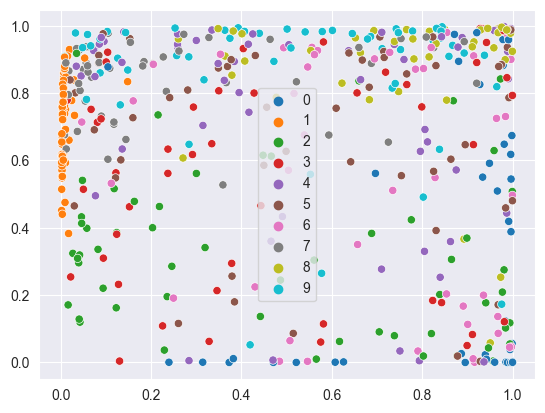

In [ ]:
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=test_target1, hue_order=[str(i) for i in range(10)])
plt.show()

Хочется сравнить с PCA

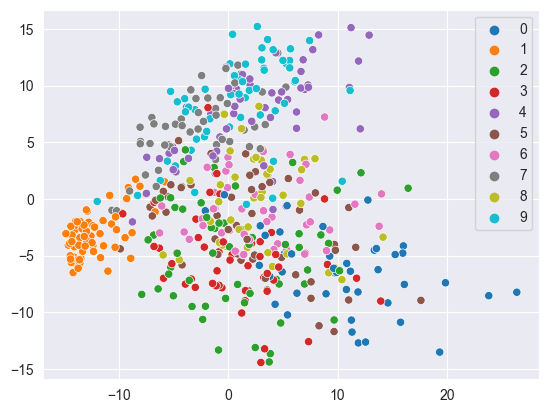

In [ ]:
data = test_data1.view(test_batch_size, 28*28).cpu()
xy_pca = PCA(n_components=2).fit_transform(data)
sns.scatterplot(x=xy_pca[:,0], y=xy_pca[:,1], hue=test_target1, hue_order=[str(i) for i in range(10)])
plt.show()

## 32D and t-SNE

In [ ]:
encoder_32 = Network(32).cuda()
optimizer = optim.Adam(encoder_32.parameters(), lr=1e-3)
criterion = nn.MSELoss()
log_32 = {
    'train_loss': [],
    'test_loss': []
}
device = 'cuda:0'
num_epoch = 25

for epoch in range(1, num_epoch+1):
    train_test(encoder_32, device, optimizer, criterion, epoch, log_32)
torch.save(encoder_32, './cache/encoder_32')

Epoch:  1


100%|██████████| 938/938 [00:13<00:00, 69.84it/s]



Train set: Average loss: 0.5679
Test set: Average loss: 0.4940
Epoch:  2


100%|██████████| 938/938 [00:12<00:00, 74.01it/s]



Train set: Average loss: 0.4674
Test set: Average loss: 0.4544
Epoch:  3


100%|██████████| 938/938 [00:12<00:00, 72.63it/s]



Train set: Average loss: 0.4411
Test set: Average loss: 0.4374
Epoch:  4


100%|██████████| 938/938 [00:13<00:00, 69.01it/s]



Train set: Average loss: 0.4293
Test set: Average loss: 0.4291
Epoch:  5


100%|██████████| 938/938 [00:13<00:00, 70.65it/s]



Train set: Average loss: 0.4232
Test set: Average loss: 0.4249
Epoch:  6


100%|██████████| 938/938 [00:13<00:00, 68.04it/s]



Train set: Average loss: 0.4197
Test set: Average loss: 0.4222
Epoch:  7


100%|██████████| 938/938 [00:13<00:00, 68.74it/s]



Train set: Average loss: 0.4174
Test set: Average loss: 0.4200
Epoch:  8


100%|██████████| 938/938 [00:14<00:00, 66.07it/s]



Train set: Average loss: 0.4158
Test set: Average loss: 0.4187
Epoch:  9


100%|██████████| 938/938 [00:13<00:00, 69.90it/s]



Train set: Average loss: 0.4146
Test set: Average loss: 0.4177
Epoch:  10


100%|██████████| 938/938 [00:12<00:00, 72.66it/s]



Train set: Average loss: 0.4136
Test set: Average loss: 0.4170
Epoch:  11


100%|██████████| 938/938 [00:12<00:00, 74.91it/s]



Train set: Average loss: 0.4129
Test set: Average loss: 0.4163
Epoch:  12


100%|██████████| 938/938 [00:12<00:00, 74.51it/s]



Train set: Average loss: 0.4123
Test set: Average loss: 0.4156
Epoch:  13


100%|██████████| 938/938 [00:13<00:00, 71.88it/s]



Train set: Average loss: 0.4118
Test set: Average loss: 0.4158
Epoch:  14


100%|██████████| 938/938 [00:12<00:00, 74.10it/s]



Train set: Average loss: 0.4113
Test set: Average loss: 0.4148
Epoch:  15


100%|██████████| 938/938 [00:12<00:00, 72.54it/s]



Train set: Average loss: 0.4110
Test set: Average loss: 0.4146
Epoch:  16


100%|██████████| 938/938 [00:12<00:00, 73.56it/s]



Train set: Average loss: 0.4107
Test set: Average loss: 0.4143
Epoch:  17


100%|██████████| 938/938 [00:12<00:00, 73.52it/s]



Train set: Average loss: 0.4104
Test set: Average loss: 0.4143
Epoch:  18


100%|██████████| 938/938 [00:12<00:00, 72.83it/s]



Train set: Average loss: 0.4101
Test set: Average loss: 0.4138
Epoch:  19


100%|██████████| 938/938 [00:13<00:00, 69.15it/s]



Train set: Average loss: 0.4099
Test set: Average loss: 0.4136
Epoch:  20


100%|██████████| 938/938 [00:12<00:00, 74.29it/s]



Train set: Average loss: 0.4097
Test set: Average loss: 0.4133
Epoch:  21


100%|██████████| 938/938 [00:12<00:00, 75.93it/s]



Train set: Average loss: 0.4095
Test set: Average loss: 0.4132
Epoch:  22


100%|██████████| 938/938 [00:12<00:00, 73.58it/s]



Train set: Average loss: 0.4094
Test set: Average loss: 0.4129
Epoch:  23


100%|██████████| 938/938 [00:12<00:00, 73.81it/s]



Train set: Average loss: 0.4092
Test set: Average loss: 0.4133
Epoch:  24


100%|██████████| 938/938 [00:12<00:00, 74.53it/s]



Train set: Average loss: 0.4091
Test set: Average loss: 0.4128
Epoch:  25


100%|██████████| 938/938 [00:13<00:00, 70.89it/s]



Train set: Average loss: 0.4090
Test set: Average loss: 0.4127


In [ ]:
data_32 = encoder_32.encode(test_data1).view(test_batch_size, 32).cpu()

C:\Users\Leslie\OneDrive\Documents\data science\Jupyter_Notebooks\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Leslie\OneDrive\Documents\data science\Jupyter_Notebooks\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


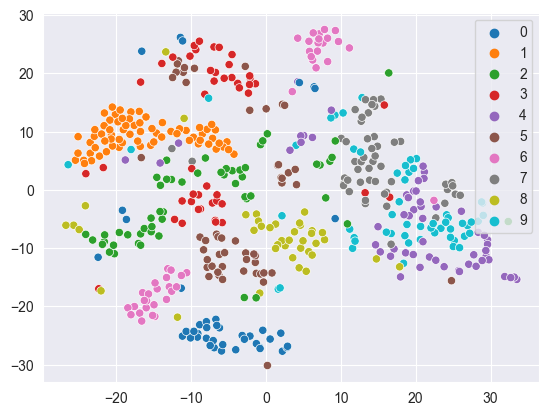

In [ ]:
xy_tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(data_32)
sns.scatterplot(x=xy_tsne[:, 0], y=xy_tsne[:, 1], hue=test_target1, hue_order=[str(i) for i in range(10)])
plt.show()

## Add noise

In [ ]:
def gen_coord(length=28, size=14):
    a = np.random.randint(length)
    if a < length/2:
        b = a + size
        return a, b
    else:
        b = a - size
        return b, a

In [ ]:
def add_noise(x, mode='crop', size=14, elementwise=False):
    x = x.clone()
    if elementwise:
        for i in range(x.shape[0]):
            if mode == 'crop':
                ax1 = gen_coord(x.shape[2], size)
                ax2 = gen_coord(x.shape[3], size)
                zero_one = np.random.randint(2)*2 - 1
                x[i, :, ax1[0]:ax1[1], ax2[0]:ax2[1]] = zero_one
            elif mode == 'mirror':
                ax1 = gen_coord(x.shape[2], size)
                ax2 = gen_coord(x.shape[3], size)
                flip_dir = np.random.randint(3)
                if flip_dir == 0:
                    flip = [1]
                elif flip_dir == 1:
                    flip = [2]
                elif flip_dir == 2:
                    flip = [1, 2]
                x[i, :, ax1[0]:ax1[1], ax2[0]:ax2[1]] = torch.flip(x[i, :, ax1[0]:ax1[1], ax2[0]:ax2[1]], flip)
            elif mode == 'gaussian':
                x[i, :, :, :] += size*torch.randn(x[i].shape)
    else:
        if np.random.randint(2):
            return x
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    return x

In [ ]:
encoder_64 = Network(64).cuda()
optimizer = optim.Adam(encoder_64.parameters(), lr=1e-3)
criterion = nn.MSELoss()
log_64 = {
    'train_loss': [],
    'test_loss': []
}
device = 'cuda:0'
num_epoch = 25

for epoch in range(1, num_epoch+1):
    train_test(encoder_64, device, optimizer, criterion, epoch, log_64)
torch.save(encoder_64, './cache/encoder_64')

Epoch:  1


100%|██████████| 938/938 [00:13<00:00, 67.50it/s]



Train set: Average loss: 0.5122
Test set: Average loss: 0.4403
Epoch:  2


100%|██████████| 938/938 [00:13<00:00, 68.92it/s]



Train set: Average loss: 0.4171
Test set: Average loss: 0.4081
Epoch:  3


100%|██████████| 938/938 [00:13<00:00, 68.92it/s]



Train set: Average loss: 0.3958
Test set: Average loss: 0.3942
Epoch:  4


100%|██████████| 938/938 [00:13<00:00, 71.99it/s]



Train set: Average loss: 0.3862
Test set: Average loss: 0.3880
Epoch:  5


100%|██████████| 938/938 [00:13<00:00, 69.23it/s]



Train set: Average loss: 0.3813
Test set: Average loss: 0.3844
Epoch:  6


100%|██████████| 938/938 [00:13<00:00, 68.17it/s]



Train set: Average loss: 0.3785
Test set: Average loss: 0.3821
Epoch:  7


100%|██████████| 938/938 [00:13<00:00, 69.10it/s]



Train set: Average loss: 0.3767
Test set: Average loss: 0.3807
Epoch:  8


100%|██████████| 938/938 [00:13<00:00, 71.69it/s]



Train set: Average loss: 0.3755
Test set: Average loss: 0.3799
Epoch:  9


100%|██████████| 938/938 [00:13<00:00, 71.11it/s]



Train set: Average loss: 0.3746
Test set: Average loss: 0.3788
Epoch:  10


100%|██████████| 938/938 [00:12<00:00, 73.06it/s]



Train set: Average loss: 0.3739
Test set: Average loss: 0.3784
Epoch:  11


100%|██████████| 938/938 [00:13<00:00, 68.87it/s]



Train set: Average loss: 0.3734
Test set: Average loss: 0.3779
Epoch:  12


100%|██████████| 938/938 [00:13<00:00, 69.57it/s]



Train set: Average loss: 0.3730
Test set: Average loss: 0.3774
Epoch:  13


100%|██████████| 938/938 [00:13<00:00, 69.51it/s]



Train set: Average loss: 0.3726
Test set: Average loss: 0.3772
Epoch:  14


100%|██████████| 938/938 [00:13<00:00, 71.56it/s]



Train set: Average loss: 0.3723
Test set: Average loss: 0.3768
Epoch:  15


100%|██████████| 938/938 [00:13<00:00, 71.22it/s]



Train set: Average loss: 0.3721
Test set: Average loss: 0.3767
Epoch:  16


100%|██████████| 938/938 [00:13<00:00, 69.80it/s]



Train set: Average loss: 0.3719
Test set: Average loss: 0.3764
Epoch:  17


100%|██████████| 938/938 [00:13<00:00, 68.81it/s]



Train set: Average loss: 0.3717
Test set: Average loss: 0.3765
Epoch:  18


100%|██████████| 938/938 [00:13<00:00, 69.12it/s]



Train set: Average loss: 0.3716
Test set: Average loss: 0.3759
Epoch:  19


100%|██████████| 938/938 [00:13<00:00, 69.20it/s]



Train set: Average loss: 0.3714
Test set: Average loss: 0.3760
Epoch:  20


100%|██████████| 938/938 [00:13<00:00, 68.11it/s]



Train set: Average loss: 0.3713
Test set: Average loss: 0.3761
Epoch:  21


100%|██████████| 938/938 [00:13<00:00, 69.71it/s]



Train set: Average loss: 0.3712
Test set: Average loss: 0.3762
Epoch:  22


100%|██████████| 938/938 [00:13<00:00, 69.52it/s]



Train set: Average loss: 0.3710
Test set: Average loss: 0.3756
Epoch:  23


100%|██████████| 938/938 [00:13<00:00, 68.93it/s]



Train set: Average loss: 0.3710
Test set: Average loss: 0.3758
Epoch:  24


100%|██████████| 938/938 [00:13<00:00, 69.27it/s]



Train set: Average loss: 0.3708
Test set: Average loss: 0.3759
Epoch:  25


100%|██████████| 938/938 [00:13<00:00, 69.08it/s]



Train set: Average loss: 0.3708
Test set: Average loss: 0.3755


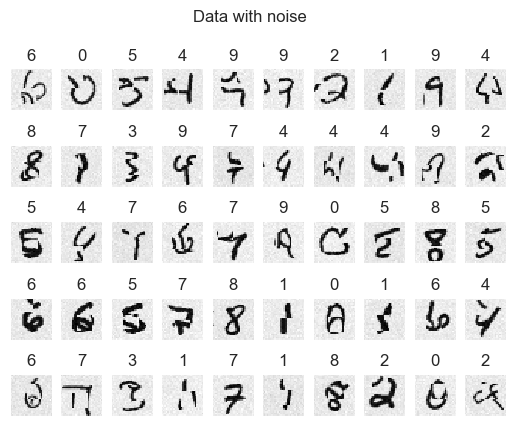

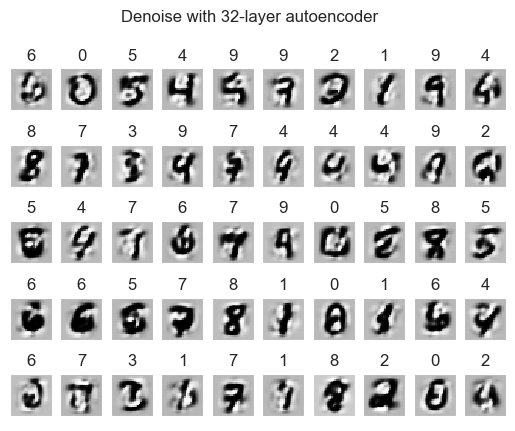

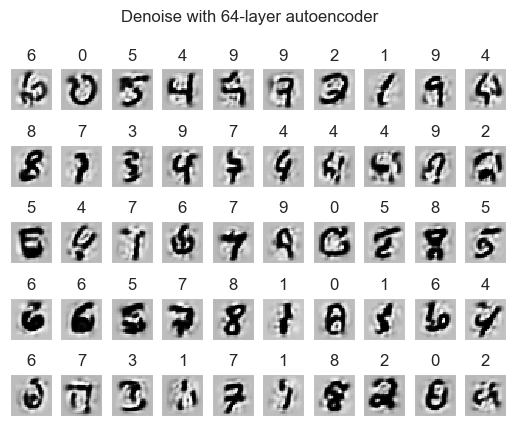

In [ ]:
data, _ = next(iter(test_loader))
# add normal noise
noised = add_noise(data, 'gaussian', size=0.1, elementwise=True)
# mirror part of images
noised = add_noise(noised, 'mirror', size=10, elementwise=True)
fig1 = plot_mnist(noised[100:150], _[100:150])
fig1.suptitle('Data with noise')
plt.show()
# denoise data
with torch.no_grad():
    denoised_32 = encoder_32(noised.to(device)).view(512, 1, 28, 28).cpu()
fig2 = plot_mnist(denoised_32[100:150], _[100:150])
fig2.suptitle('Denoise with 32-layer autoencoder')
plt.show()
with torch.no_grad():
    denoised_64 = encoder_64(noised.to(device)).view(512, 1, 28, 28).cpu()
fig3 = plot_mnist(denoised_64[100:150], _[100:150])
fig3.suptitle('Denoise with 64-layer autoencoder')
plt.show()